#### Libraries

In [7]:
import copy, time
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [8]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Generic Utils 

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def check(val, msg):
    '''Checks whether val is nan or inf and prints msg if True'''
    if (val * 0 != 0): print(msg); pdb.set_trace()
        
def to_numpy(t):
    '''PyTorch tensor to numpy array'''
    return t.detach().to('cpu').numpy()

#### Model

In [10]:
# PyTorch
device = torch.device('cpu')

# Data
X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1).to(device)
Y = - X*X*X*X + 3*X*X + 1

# Plotting range
x_range = torch.arange(-5,5,0.05).reshape(-1,1)

# BBVI hyperparameters
fn_samples = 1000 # function samples after convergence
learning_rate = 1e-4 # learning rate

In [27]:
class SingleLayerNet(nn.Module):
    def __init__(self, h):
        super(SingleLayerNet, self).__init__()
        self.h = h

        # First 31 are means, last 31 are log_stds
        self.lambdas = nn.Parameter(torch.zeros(62))
        self.lambdas.data[:31].fill_(0.0)
        self.lambdas.data[31:].fill_(0.5)
        
    def forward(self, x, sample):
        
        # Unroll sample weights
        w1 = sample[  :10].reshape(1,10)
        b1 = sample[10:20].reshape(1,10)
        w2 = sample[20:30].reshape(10,1)
        b2 = sample[30:31].reshape( 1,1)
        
        # Forward pass
        x = (x-w1) / b1 # x = x @ w1 + b1 # 
        x = torch.exp(-x*x) # torch.exp(-(x-w1)*(x-w1) / (b1*b1)) 
        x = x @ w2 + b2
        return x 

In [28]:
def BBVI(x, y, model, optimizer, num_samples=1000, epochs=int(20e3), seed=None):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else 10)
        
    # Track ELBO statistics
    elbo_meter = AverageMeter()
    elbo_hist = []
    
    # Prior
    p_dist = Normal(torch.zeros(31), 3.16 * torch.ones(31)) 
    
    for ix_e in range(epochs):
        gradients = torch.zeros(62)
        for ix_s in range(num_samples):
            
            # Distributions
            q_dist = Normal(model.lambdas[:31], F.softplus(model.lambdas[31:])) # torch.exp

            # Sample weights
            sample = q_dist.sample()
                        
            # Likelihood
            y_hat = model.forward(x, sample)
            log_l = Normal(y_hat.squeeze(), 0.1 * torch.ones(6)).log_prob(y.squeeze()).sum()
            
            # Regularization
            log_p = p_dist.log_prob(sample).sum()
            log_q = q_dist.log_prob(sample).sum()
            
            # ELBO = log likelihood + log p - log q
            elbo = (log_l + log_p - log_q).squeeze()
            
            # Store gradients
            model.zero_grad()
            optimizer.zero_grad()
            log_q.backward()
            gradients += model.lambdas.grad.data * elbo
                
            # Update ELBO statistics
            elbo_meter.update(elbo.item())
            elbo_hist.append(elbo.item())
        
        if ix_e % 50 == 10: 
            print(ix_e, elbo_meter.avg)
            torch.save(model.lambdas.data.clone(), './weights/hw2.model.lambdas-e{}.data.pth'.format(ix_e))
                
        # Step gradient: 
        optimizer.zero_grad()
        model.lambdas.grad.data = - gradients / num_samples
        optimizer.step()

    return model, elbo_hist

In [29]:
model = SingleLayerNet(10)
# model.lambdas.data = current_weights.data
optimizer = torch.optim.SGD([model.lambdas], lr=2e-4)
BBVI(X, Y, model, optimizer)

10 -2237.0162378151635
60 -1780.7557165757476
110 -1546.9811413992118
160 -1406.9753582975968
210 -1319.717988763746
260 -1259.3227482049583
310 -1215.4269871541603
360 -1180.4919779152488
410 -1148.5949303686136
460 -1119.0612643545155
510 -1090.0623425985737
560 -1062.1983825471439
610 -1034.9866608101054
660 -1008.5290566046133
710 -982.7003348030702
760 -958.0065037797284
810 -935.2708291571414
860 -913.4363863329738
910 -892.7751760388907
960 -873.3928908912111
1010 -855.1296865891514
1060 -837.6373378351699
1110 -821.3696511066481
1160 -805.8821321698697
1210 -791.3158261739666
1260 -777.8811217411776
1310 -764.9891864061625
1360 -752.7986311586535
1410 -741.4336603522244
1460 -730.5222564075843
1510 -719.9457152107486
1560 -709.6525299624553
1610 -699.9661828552663
1660 -690.7419241213491
1710 -682.0302587743745
1760 -673.8338249116689
1810 -665.8981735255022
1860 -658.600073445209
1910 -651.3446227022148
1960 -644.0558057380376
2010 -636.7402079294548
2060 -629.7563950510039
21

17210 nan
17260 nan
17310 nan
17360 nan
17410 nan
17460 nan
17510 nan
17560 nan
17610 nan
17660 nan
17710 nan
17760 nan
17810 nan
17860 nan
17910 nan
17960 nan
18010 nan
18060 nan
18110 nan
18160 nan
18210 nan
18260 nan
18310 nan
18360 nan
18410 nan
18460 nan
18510 nan
18560 nan
18610 nan
18660 nan
18710 nan
18760 nan
18810 nan
18860 nan
18910 nan
18960 nan
19010 nan
19060 nan
19110 nan
19160 nan
19210 nan
19260 nan
19310 nan
19360 nan
19410 nan
19460 nan
19510 nan
19560 nan
19610 nan
19660 nan
19710 nan
19760 nan
19810 nan
19860 nan
19910 nan
19960 nan


(SingleLayerNet(),
 [-6722.8974609375,
  -1793.145751953125,
  -2063.68701171875,
  -3475.056884765625,
  -3583.700927734375,
  -2905.31591796875,
  -3061.439453125,
  -2251.34326171875,
  -2067.701171875,
  -3409.26123046875,
  -2287.845947265625,
  -1914.009765625,
  -1486.510009765625,
  -3899.24951171875,
  -3488.455810546875,
  -2276.110107421875,
  -2750.892578125,
  -2104.06005859375,
  -4388.50048828125,
  -2003.4842529296875,
  -7670.8974609375,
  -3663.676513671875,
  -2135.81494140625,
  -2579.852294921875,
  -1941.6380615234375,
  -1918.998291015625,
  -1587.621826171875,
  -1881.5125732421875,
  -3247.29931640625,
  -1713.9605712890625,
  -2005.0592041015625,
  -2500.451416015625,
  -2111.19873046875,
  -1926.7177734375,
  -4746.54736328125,
  -4273.2587890625,
  -2177.558349609375,
  -2832.89404296875,
  -1633.2369384765625,
  -2521.217529296875,
  -2160.662353515625,
  -3413.626953125,
  -1928.5772705078125,
  -3194.07470703125,
  -2443.54638671875,
  -2038.4366455078125

In [386]:
# current_weights = model.lambdas.data.clone()
# torch.save(current_weights, './hw2.model.lambdas.data.softplusstdv.pth')

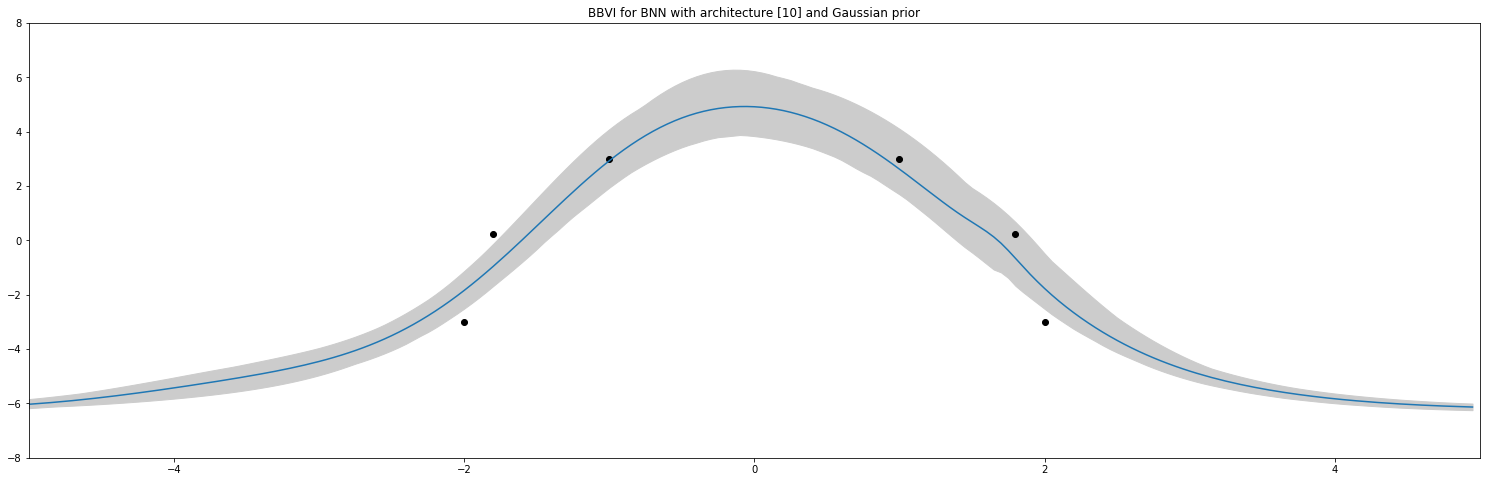

In [26]:
preds = []
for _ in range(5000):
    pred = model(x_range, Normal(model.lambdas[:31], torch.exp(model.lambdas[31:])).sample())
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
bounds = (np.sort(preds, axis=1)[:, 1], np.sort(preds, axis=1)[:,-1])
mean = np.mean(preds, axis=1)

plt.gca().set_title('BBVI for BNN with architecture [10] and Gaussian prior')
plt.gca().fill_between(x_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')

plt.plot(to_numpy(x_range), mean)
# plt.scatter(X,Y)
plt.axis([-5,5,-8,8])
plt.show()

In [89]:
# plt.plot(to_numpy(x_range), to_numpy(model(x_range)))
# plt.scatter(X,Y)

In [ ]:
# # Plot
# fnames = [ ('1_10_1.pth', '[1,10,1]'), ('1_50_1.pth', '[1,50,1]'), ('1_10_10_1.pth', '[1,10,10,1]'), ('1_50_50_1.pth', '[1,50,50,1]') ]

# for i, (fname, name) in enumerate(fnames):
#   samples = torch.load(fname).squeeze().transpose(0,1).detach().cpu().numpy()
#   upper_95 = np.sort(samples, axis=1)[:, 50] 
#   lower_95 = np.sort(samples, axis=1)[:,-50]
  
#   # Plot
#   plt.subplot(2,2,i+1)
#   plt.gca().set_title('BNN with Gaussian prior and network architecture ' + name)
#   plt.gca().fill_between(x_range.reshape(-1), upper_95, lower_95, color="#cccccc")
#   plt.scatter(X, Y, color='black', marker='o')

# plt.show()

In [ ]:
# if False:
#             print('''---------------- id_x {} ---------- 
#                 \n means {} 
#                 grad means {} 
#                 softstds {} 
#                 grad softstds {} 
#                 model.linear.weight.data {} 
#                 model.linear.weight.grad {} 
#                 model.linear.bias.data {} 
#                 model.linear.bias.grad {} 
#                 log_q {} 
#                 log_p {} 
#                 elbo {} '''.format(
#                 ix_e, means, grad_means, softstds, grad_softstds, 
#                 model.linear.weight.data, model.linear.weight.grad, 
#                 model.linear.bias.data, model.linear.bias.grad, log_q, 
#                 log_p, elbo))
# # Plot ELBO statistics
# if ix_e % 10000 == 100:
#     display.clear_output()
#     plt.plot(elbo_history)
#     plt.show()
# - 0.5 * sum((p**2).sum() for p in self.get_sampled_weights()) / self.prior_sigma**2
#         if ix_e % 1000 == 20: 
#             display.clear_output()
#             # ELBO
#             plt.plot(elbo_hist)
#             plt.show()
#             # PLOT
#             y_range = model(x_range, Normal(model.lambdas[:31], torch.exp(model.lambdas[31:])).sample())
#             plt.plot(to_numpy(x_range), to_numpy(y_range))
#             plt.scatter(X,Y)
#             plt.show()
